In [1]:
# # GOOGLE COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
# change working directory if not done already
if os.getcwd().split('/')[-2] != 'My Drive':
  os.chdir('drive/MyDrive/laba')

Mounted at /content/drive


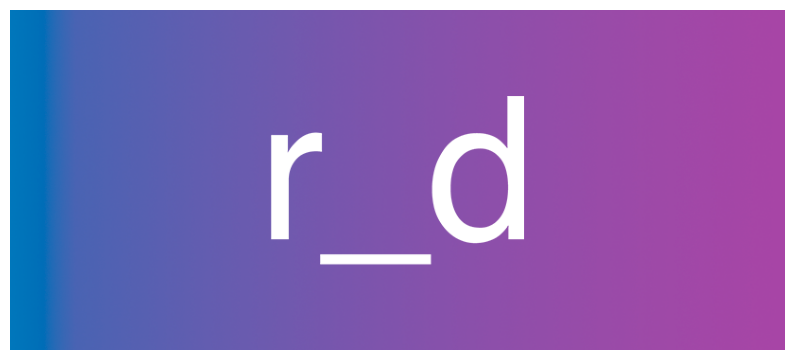

In [2]:
import rd_utils as rdu
rdu.show_logo()

<font size="10">Lekce 13 - domácí úloha</font>

<font size="6">Velké jazykové modely - praktické využití</font>

- V následující úloze si vyzkoušíte naimplementavat úlohu RAG
- Rozdíl oproti lekci bude ten, že budete pracovat s dokumentem pdf
  - Načtení a úprava textu vyžadují trochu práce navíc
- Nakonec použijete LLM na odpovězení několika otázek
- Narozdíl od předchozích úloh není kód připravený, ale budete jej sestavovat sami
- Jediná připravená část se týká načtení dokument z .pdf

**Instrukce:**

1. vytvořte nový index (tubulku) v databázi Pinecone. V případě zájmu můžete zkusit i jinou databázovou službu
2. načtěte dokument `svaz_vcelaru.pdf` nebo jiný dokument (viz bonus) a uložte jej do databáze
3. nechte LLM odpovědět několik dotazů (viz níže). Je možné, že některé dotazy LLM nezodpoví správně nebo vůbec.
4. zvolte různé hodnoty parametrů `chunk_size` a `chunk_overlap` v objektu `CharacterTextSplitter`. Nechte kód proběhnout vícekrát pro tyto různé hodnoty a porovnejte vygenerované odpovědi z předešlého bodu. Liší se odpovědi nějak? Okomentujte.

**Dotazy k zodpovězení LLM k dokumentu svaz_vcelaru.pdf:**

- Je včela medonosná kraňská vhodná pro podmínky ČR?
- Kolik matek odchoval Michal Doubek?
- Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?

**Bonus:**

- Využijte libovolné vlastní pdf (a zvolte si vlastní dotazy k zodpovězení)
- pdf by mělo obsahovat alespoň jednu tabulku a jedna z otázek by měla směřovat na hodnoty v této tabulce
- pdf nahrajte společně s řešením úkolu (nebo mi zašlete přes Discord)

## Kód pro načtení z PDF

In [3]:
FLD_DATA = './lessons/L13_LLM_langchain_ChatGPT/domaci_uloha'

In [ ]:
!pip install python-dotenv
!pip install pinecone-client
!pip install langchain
!pip install pypdf2
!pip install langchain_openai
!pip install langchain_pinecone

In [5]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema.document import Document
from PyPDF2 import PdfReader

In [6]:
file_obj = open(os.path.join(FLD_DATA, 'svaz_vcelaru.pdf'), 'rb')
reader = PdfReader(file_obj)

In [7]:
# načtení a očistění textu
output = []
for i in range(len(reader.pages)):
    page = reader.pages[i]
    output.append(page.extract_text())

loaded_text = ''.join(output)
loaded_text = loaded_text.replace('\n', '')

In [8]:
loaded_text

'       VÝROČNÍ ZPRÁVA 20 21 Kontrola realizace šlechtitelského programu plemene včely medonosné kraňské    Český svaz včelařů, z. s.  Křemencova 177/8 , 115 24, Praha 1, IČ: 00 443 239      Uznané chovatelské sdružení včely medonosné kraňské  Rozho dnutím MINISTERSTVA ZEMĚ DĚLSTVÍ ČESKÉ REPUBLIKY, č. j. 120109/01–7010 , ze dne 11. 5. 2001          Kontrola realizace šlechtitelského programu  Dle zákona č. 154/2000 sb. o šlechtění, plemenitbě a evidenci hosp odářských zvířat a o změně některých sou visejících zákonů (plemenářský zákon)       Výroční zpráva za rok 2021                                 Obsah:    1. Výchozí předpo klady 1.2. Organizace šlechtitelské práce v chovu včel v ČR 1.3. Směr šlechtění 1.4. Stavy včelstev v kontrole užitkovosti 2. Chovný cíl a standard plemene 2.1. Hlavní směry chovného cíle 2.2. Zákla dní parametry chovného cíle 3. Realizace šlechtitelského programu 3.1. Účastníci programu 3.2. Vyhodn ocení sledovaných vlastností za rok 2021 4. Přehled počtu odchov

In [9]:
def split_to_docs(text_string):
    """Rozdělí text formátovaný jako string a každý chunk převede na Document"""
    text_splitter = CharacterTextSplitter(
       separator='.',
       chunk_size=500,
       chunk_overlap=500)
    docs = [Document(page_content=x) for x in text_splitter.split_text(text_string)]
    return docs

In [10]:
docs = split_to_docs(loaded_text)

In [ ]:
docs

In [12]:
from dotenv import load_dotenv

In [13]:
os.listdir()

['datasets',
 'rd_logo.png',
 'requirements.txt',
 'lessons',
 '__pycache__',
 'rd_utils.py',
 '.ipynb_checkpoints',
 '.env']

In [14]:
load_dotenv()

True

In [15]:
from pinecone import Pinecone, ServerlessSpec

In [16]:
# načtení přístupových údajů
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
PINECONE_ENV = os.getenv('PINECONE_ENV')

In [17]:
pc = Pinecone(api_key=PINECONE_API_KEY)

In [18]:
# jméno a dimenze indexu (tabulky)
# tvořené alfanumerickými znaky a pomlčkami
index_name = 'my-index'
dimension = 1536

In [19]:
# vytvoření indexu?
recreate_index = True

if recreate_index:
    # smazání stávající tabulky
    try:
        pc.delete_index(index_name)
    except:
        # not nice - error type should be specified
        pass

    # nostavení odpovídá Free tieru na Pinecone
    pc.create_index(
      name=index_name,
      dimension=dimension,
      metric="cosine",
      spec=ServerlessSpec(
        cloud="aws",
        region=PINECONE_ENV
      )
    )

Vytvoření embeddings a vložení do vektorové databáze

In [20]:
# vytvoření objektu embeddings pro následný převod textu před uložením do databáze
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [21]:
# vložení do vektorové databáze, včetně vytvoření embeddings
# standardizovaný přístup pomocí langchain_pinecone
from langchain_pinecone import PineconeVectorStore
doc_db = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name)

In [22]:
# objekt přístupu k tabulce v databázi
type(doc_db)

langchain_pinecone.vectorstores.PineconeVectorStore

In [ ]:
Objekty pro interakci s LLM modelem

In [23]:
# vytvoření chat modelu
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

In [24]:
# vytvoření obejektu pro odpověď na dotaz
from langchain.chains import RetrievalQA

def retrieval_answer(query):
    qa = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type='stuff',
        retriever=doc_db.as_retriever()
    )
    return qa.invoke(query)

In [25]:
# dotaz
query = 'Je včela medonosná kraňská vhodná pro podmínky ČR?'

# odpověď
retrieval_answer(query)

{'query': 'Je včela medonosná kraňská vhodná pro podmínky ČR?',
 'result': 'Ano, včela medonosná kraňská se v podmínkách ČR plně osvědčila pro své vlastnosti. Její rychlý jarní rozvoj umožňuje využití silných časných snůšek, které v našich klimatických a přírodních podmínkách představují převážnou část snůškových zdrojů. Plemeň je i nadále šlechtěn na kombinaci požadovaných užitkových vlastností s výrazným zaměřením na mírnost a odolnost proti nemocem.'}

In [26]:
# dotaz
query = 'Kolik matek odchoval Michal Doubek?'

# odpověď
retrieval_answer(query)

{'query': 'Kolik matek odchoval Michal Doubek?',
 'result': 'Michal Doubek odchoval 329 matek.'}

In [28]:
# dotaz
query = 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?'

# odpověď
retrieval_answer(query)


{'query': 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?',
 'result': 'Omlouvám se, ale ve poskytnutých informacích není uveden počet chovů v kategorii vyšších šlechtitelských chovů v roce 2014.'}

In [44]:
def split_to_docs(text_string):
    """Rozdělí text formátovaný jako string a každý chunk převede na Document"""
    text_splitter = CharacterTextSplitter(
       separator='.',
       chunk_size=700,
       chunk_overlap=200)
    docs = [Document(page_content=x) for x in text_splitter.split_text(text_string)]
    return docs

In [45]:
docs = split_to_docs(loaded_text)

In [46]:
doc_db = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name)

In [47]:
# dotaz
query = 'Je včela medonosná kraňská vhodná pro podmínky ČR?'

# odpověď
retrieval_answer(query)

{'query': 'Je včela medonosná kraňská vhodná pro podmínky ČR?',
 'result': 'Ano, včela medonosná kraňská se v podmínkách České republiky plně osvědčila pro své vlastnosti. Její rychlý jarní rozvoj umožňuje využití silných časných snůšek, které v českých klimatických a přírodních podmínkách představují převážnou část snůškových zdrojů.'}

4.TAHLE ODPOVED JE KRATSI OPROTI PUVODNI VERZI

In [48]:
# dotaz
query = 'Kolik matek odchoval Michal Doubek?'

# odpověď
retrieval_answer(query)

{'query': 'Kolik matek odchoval Michal Doubek?',
 'result': 'Michal Doubek odchoval 329 matek.'}

In [49]:
# dotaz
query = 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?'

# odpověď
retrieval_answer(query)


{'query': 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?',
 'result': 'Omlouvám se, ale z poskytnutých informací není možné zjistit počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014.'}

In [66]:
def split_to_docs(text_string):
    """Rozdělí text formátovaný jako string a každý chunk převede na Document"""
    text_splitter = CharacterTextSplitter(
       separator='.',
       chunk_size=200,
       chunk_overlap=200)
    docs = [Document(page_content=x) for x in text_splitter.split_text(text_string)]
    return docs

In [67]:
docs = split_to_docs(loaded_text)

In [68]:
doc_db = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name)

In [69]:
# dotaz
query = 'Je včela medonosná kraňská vhodná pro podmínky ČR?'

# odpověď
retrieval_answer(query)

{'query': 'Je včela medonosná kraňská vhodná pro podmínky ČR?',
 'result': 'Ano, včela medonosná kraňská se v podmínkách České republiky plně osvědčila pro své vlastnosti, včetně rychlého jarního rozvoje a odolnosti proti nemocem.'}

In [ ]:
4. JINA ODPOVED OPROTI OSTATNIM VERZIIM

In [70]:
# dotaz
query = 'Kolik matek odchoval Michal Doubek?'

# odpověď
retrieval_answer(query)

{'query': 'Kolik matek odchoval Michal Doubek?',
 'result': 'Michal Doubek odchoval 329 matek.'}

In [71]:
# dotaz
query = 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?'

# odpověď
retrieval_answer(query)


{'query': 'Jaký byl počet chovů v kategorii vyšší šlechtitelské chovy v roce 2014?',
 'result': 'Omlouvám se, ale z poskytnutých informací není možné zjistit počet chovů v kategorii vyšších šlechtitelských chovů v roce 2014.'}